In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler

In [2]:
dataset_train = pd.read_csv('btc_ohlcv_train.csv')
train_set = dataset_train.iloc[:, [1, 5]].values  # selecting oepn and volume columns
sc = MinMaxScaler(feature_range=(0, 1))
train_set_scaled = sc.fit_transform(train_set)

def create_sequences(data, seq_length):
    '''
    Function to create sequences of data (since we are using an RNN), so at each time step, we will input a sequence of data
    Note that for now we care about predicting the 'open' price
    '''
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length, 0]  # choosing the 'open' price as the label we want to predict (i.e. the next day's open price)
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)


sequence_length = 30  # number of days to look back to predict the next day's open price (i.e. 60 days)


X_train, y_train = create_sequences(train_set_scaled, sequence_length)


# Convert the data to PyTorch tensors 
X_train_tensors = torch.tensor(X_train, dtype=torch.float32)
y_train_tensors = torch.tensor(y_train, dtype=torch.float32)


print(f"X_train shape: {X_train_tensors.shape}")
print(f"y_train shape: {y_train_tensors.shape}")


X_train shape: torch.Size([1322, 30, 2])
y_train shape: torch.Size([1322])


In [3]:
class BitcoinRNN(nn.Module):
    def __init__(self,input_size,hidden_size_LSTM, num_layers_LSTM, output_size=1):
        super(BitcoinRNN,self).__init__()
        # define my parameters
        self.input_size = input_size
        self.hidden_size_LSTM = hidden_size_LSTM
        self.num_layers_LSTM = num_layers_LSTM
        self.output_size = output_size

        # define our layers 
        self.LSTM_1 = nn.LSTM(input_size=input_size,hidden_size=hidden_size_LSTM, num_layers=num_layers_LSTM,bias=True,batch_first=True,dropout=0.2) 
        self.dropout = nn.Dropout(0.2)
        self.output_layer = nn.Linear(in_features=hidden_size_LSTM, out_features=output_size,bias= True)

        
    
    def forward(self,x):
        h_0 = torch.zeros(self.num_layers_LSTM, x.size(0), self.hidden_size_LSTM).to(x.device) # shape(num_layers,batch_size,hidden_size)
        c_0 = torch.zeros(self.num_layers_LSTM, x.size(0), self.hidden_size_LSTM).to(x.device)  # shape: (num_layers, batch_size, hidden_size)
        out, (h_n,c_n) = self.LSTM_1(x,(h_0,c_0)) # notice that we don't care about h_n here 
        out = out[:,-1,:] # only care about the output of the last time step not all!!!
        out = self.dropout(out)

        out = self.output_layer(out)
        # no activation function on the last layer 
        return out 

input_size = 2  # open and volume features 
hidden_size = 50  # Number of hidden units inside the RNN(or LSTM)
num_layers = 4  # Number of LSTM layers (stacked on top of each other)
output_size = 1  # 1 output neuron to predict the next day's open price
batch_size = 32 # batch size 

model = BitcoinRNN(input_size, hidden_size, num_layers, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [4]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Create data loaders (without shuffling to preserve order)
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)


Epoch [1/150], Train Loss: 0.1720
Epoch [2/150], Train Loss: 0.1362
Epoch [3/150], Train Loss: 0.1138
Epoch [4/150], Train Loss: 0.1059
Epoch [5/150], Train Loss: 0.0747
Epoch [6/150], Train Loss: 0.0403
Epoch [7/150], Train Loss: 0.0537
Epoch [8/150], Train Loss: 0.0407
Epoch [9/150], Train Loss: 0.0224
Epoch [10/150], Train Loss: 0.0210
Epoch [11/150], Train Loss: 0.0166
Epoch [12/150], Train Loss: 0.0131
Epoch [13/150], Train Loss: 0.0135
Epoch [14/150], Train Loss: 0.0141
Epoch [15/150], Train Loss: 0.0151
Epoch [16/150], Train Loss: 0.0141
Epoch [17/150], Train Loss: 0.0128
Epoch [18/150], Train Loss: 0.0129
Epoch [19/150], Train Loss: 0.0123
Epoch [20/150], Train Loss: 0.0109
Epoch [21/150], Train Loss: 0.0091
Epoch [22/150], Train Loss: 0.0089
Epoch [23/150], Train Loss: 0.0100
Epoch [24/150], Train Loss: 0.0101
Epoch [25/150], Train Loss: 0.0106
Epoch [26/150], Train Loss: 0.0123
Epoch [27/150], Train Loss: 0.0126
Epoch [28/150], Train Loss: 0.0126
Epoch [29/150], Train Loss: 0

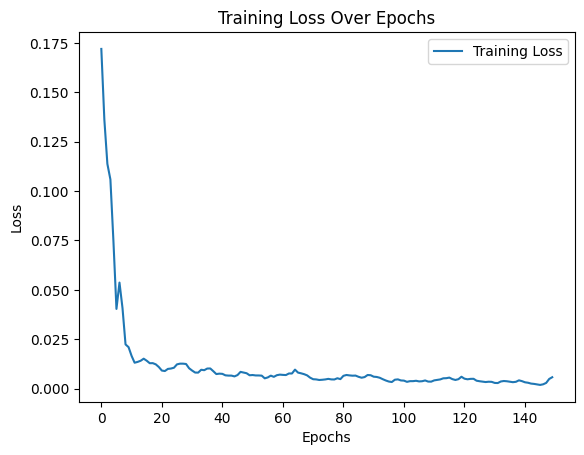

In [5]:
num_epochs = 150
train_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_batch)
        outputs = outputs.squeeze()  # Remove unnecessary dimensions for comparison with y_batch

        # Compute the loss
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_train_loss += loss.item() * X_batch.size(0)

    # Average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}')

# Plotting training loss curve
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation on training Data 

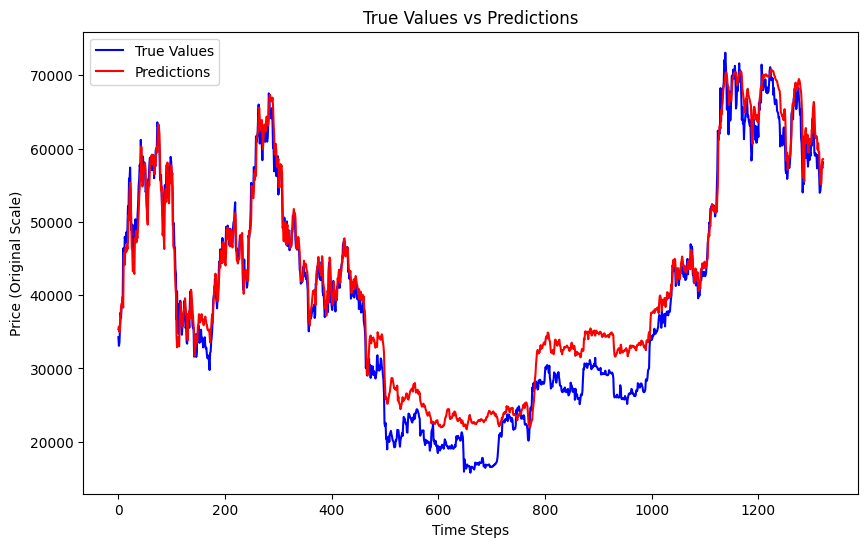

In [6]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculations
    predictions = model(X_train_tensor).reshape(-1,1)

predictions_with_dummy = np.zeros((predictions.shape[0], 2))  # Create a (1292, 2) array with zeros
predictions_with_dummy[:, 0] = predictions[:, 0]  # Place predictions in the first column

# Inverse transform using the scaler
predictions_original_scale = sc.inverse_transform(predictions_with_dummy)[:, 0]  # Inverse transform and keep only the first column

# Do the same for the true values
y_train_with_dummy = np.zeros((y_train_tensor.shape[0], 2))  # Create a (1292, 2) array with zeros
y_train_with_dummy[:, 0] = y_train_tensor.reshape(-1)  # Place true values in the first column

# Inverse transform and keep only the first column
y_train_original_scale = sc.inverse_transform(y_train_with_dummy)[:, 0]

# Plot the true values vs. the predictions
plt.figure(figsize=(10, 6))
plt.plot(y_train_original_scale, label='True Values', color='b')
plt.plot(predictions_original_scale, label='Predictions', color='r')
plt.title('True Values vs Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Price (Original Scale)')
plt.legend()
plt.show()

### Evaluating on Test Data 

In [8]:
dataset_test = pd.read_csv('btc_ohlcv_test_with_train_window.csv')

# Use the same columns ('open' and 'volume') as the training set
test_set = dataset_test.iloc[:, [1, 5]].values  # 'open' and 'volume' columns

# Scale the test set using the same scaler that was fitted on the training set
test_set_scaled = sc.transform(test_set)

# Create sequences for the test set
X_test, y_test = create_sequences(test_set_scaled, sequence_length)

# Convert the test set to PyTorch tensors
X_test_tensors = torch.tensor(X_test, dtype=torch.float32)
y_test_tensors = torch.tensor(y_test, dtype=torch.float32)

print(f"X_test shape: {X_test_tensors.shape}")
print(f"y_test shape: {y_test_tensors.shape}")

X_test shape: torch.Size([31, 30, 2])
y_test shape: torch.Size([31])


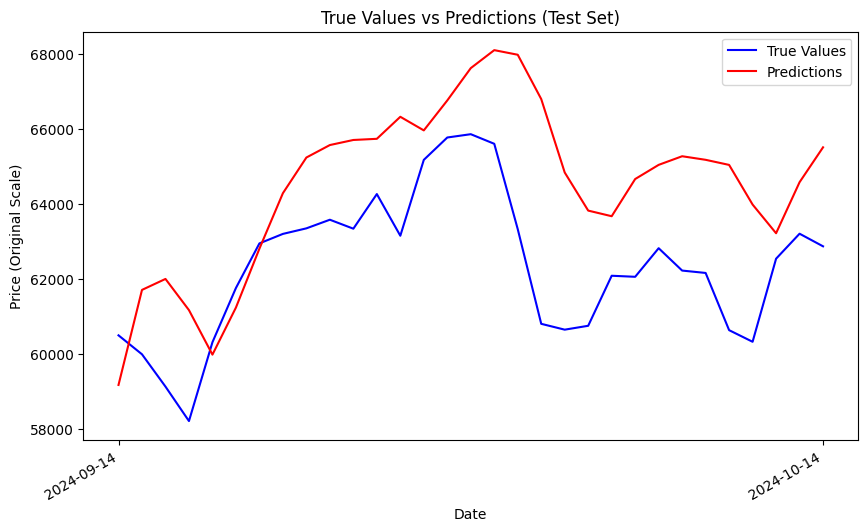

In [9]:
model.eval()
# Disable gradient calculation
with torch.no_grad():
    # Get predictions for the test set
    test_predictions = model(X_test_tensors).reshape(-1, 1)

# Inverse transform the predictions and true values
test_predictions_with_dummy = np.zeros((test_predictions.shape[0], 2))
test_predictions_with_dummy[:, 0] = test_predictions[:, 0]  # Place predictions in the first column
test_predictions_original_scale = sc.inverse_transform(test_predictions_with_dummy)[:, 0]

# Inverse transform the true test values
y_test_with_dummy = np.zeros((y_test_tensors.shape[0], 2))
y_test_with_dummy[:, 0] = y_test_tensors.reshape(-1)

y_test_original_scale = sc.inverse_transform(y_test_with_dummy)[:, 0]

test_dates = dataset_test['timestamp'].values[sequence_length:]
# Plot the true values vs. the predictions for the test set
plt.figure(figsize=(10, 6))
plt.plot(test_dates, y_test_original_scale, label='True Values', color='b')
plt.plot(test_dates, test_predictions_original_scale, label='Predictions', color='r')
plt.title('True Values vs Predictions (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price (Original Scale)')
plt.legend()

# Set the x-axis ticks to only show the first and last dates
plt.xticks([test_dates[0], test_dates[-1]], [test_dates[0], test_dates[-1]])

# Rotate the date labels for better readability
plt.gcf().autofmt_xdate()

plt.show()


# Single Prediction 

In [10]:
last_30_days = dataset_test.iloc[-30:, [1, 5]].values
last_30_days_scaled = sc.transform(last_30_days)
last_30_days_scaled = np.expand_dims(last_30_days_scaled, axis=0)  # Shape (1, 30, 2)

last_30_days_tensor = torch.tensor(last_30_days_scaled, dtype=torch.float32)

model.eval()

with torch.no_grad():
    prediction = model(last_30_days_tensor)
prediction_with_dummy = np.zeros((1, 2))  # Create a dummy 2-column array (since scaler expects 2 features)
prediction_with_dummy[0, 0] = prediction  # Place the prediction in the first column

# Inverse transform
prediction_original_scale = sc.inverse_transform(prediction_with_dummy)[:, 0]  # Keep only the first column (open price)

# Print the predicted next day's "open" price
print(f"Predicted open price for the next day: {prediction_original_scale[0]}")

Predicted open price for the next day: 65538.38649967193
